# Graph matching

Some of this lesson is taken directly from the [`graspologic` tutorials on graph matching](https://microsoft.github.io/graspologic/latest/tutorials/index.html#matching), mostly written by Ali Saad-Eldin with help from myself.

## Why match graphs? 

Graph matching comes up in a ton of different contexts!

- Computer vision: comparing objects
- Communication networks:
  - Finding noisy subgraphs
  - Matching different social networks
- Neuroscience: finding the same nodes on different sides of a brain

```{figure} ./images/graph-match-cv.jpeg

Application of graph matching in computer vision. Figure from [here](https://cv.snu.ac.kr/research/~ProgGM/).
```

```{figure} ./images/the-wire.png

Potential application of graph matching in a communication subnetwork. Figure from *The Wire*, Season 3, Episode 7.
```

```{figure} ./images/match-neuron-morphology.png

Application of graph matching to predict homologous neurons in a brain connectome.
```

## Permutations

To start to understand graph matching, we first need to understand permutations and 
permutation matrices.

A [**permutation**](https://en.wikipedia.org/wiki/Permutation) can be thought of as a
specific ordering or arrangement of some number of objects. 

```{admonition} Question
:class: tip

How many permutations are there of $n$ objects?
```

Permutations, for us, will be represented by [**permutation matrices**](https://en.wikipedia.org/wiki/Permutation_matrix).
A permutation matrix is $n \times n$, with all zeros except for $n$ 1s. Let's look at
what a permutation matrix times a vector looks like.

```{figure} ./images/perm-matrix.png
:width: 200px

A permutation matrix multiplied by a vector. The red elements of the matrix indicate the 
1s. Image from [Wikipedia](https://en.wikipedia.org/wiki/Permutation_matrix).
```

So, we see that if we look at the permutation matrix, the *row index* represents the 
index of the original position of object $i$. The *column index* represents the new
position of an object. So, if we have a 1 at position $(1, 4)$, that means the first
object in the original arrangement moves to be the fourth object.

Note that this also works for matrices: each column of a matrix $A$ would be permuted
the same way as the vector in the example above. So, we can think of 

$$PA$$

as permuting the *rows* of the matrix $A$.

Note that post-multiplication by the matrix $P$ works the opposite way (try it out 
yourself if you don't see this, or refer to the Wikipedia article). For this reason, if
we wanted to permute the columns of $A$ in the same way, we'd have to do

$$AP^T$$

```{admonition} Question
:class: tip

How can we permute the rows *and* columns of the matrix $A$ in the same way? Why do 
we care about this for networks?
```

## Graph matching problem

Why do we care about permutations for the problem of [**graph matching**](https://en.wikipedia.org/wiki/Graph_matching)?
Graph matching refers to the problem of finding a mapping between the nodes of one graph ($A$)
and the nodes of some other graph, $B$. For now, consider the case where the two networks
have exactly the same number of nodes. Then, this problem amounts to finding a *permutation* 
of the nodes of one network with regard to the nodes of the other. Mathematically, we
can think of this as comparing $A$ vs. $P B P^T$. 

```{note}
You can think of graph matching as a more general case of the [**graph isomorphism problem**](https://en.wikipedia.org/wiki/Graph_isomorphism_problem).

In the case of graph matching, we don't assume that the graphs must be exactly the same
when matched, while for the graph isomorphism problem, we do.
```

How can we measure the quality of this alignment between two networks, given what 
we've talked about so far? Like when we talked about approximating matrices in the [embeddings](embeddings.ipynb)
section, one natural way to do this is via the Frobenius norm of the difference. 

$$e(P) = \|A - PBP^T\|_F$$

```{admonition} Question
:class: tip

In words, what is this quantity $e(P)$ measuring with respect to the edges of two
unweighted networks?
```

We can use this same definition above for any type of network: unweighted or weighted, 
directed or undirected, with or without self-loops.

```{figure} ./images/network-matching-explanation.png
Diagram explaining graph matching.
```


## Solving the graph matching problem

Many solutions for the problem above have been proposed - note that all of these are 
approximate solutions, and they tend to scale fairly poorly (in the number of nodes)
compared to some of the other algorithms we have discussed so far. Nevertheless, a lot 
of progress has been made. I'm just going to focus on one family of algorithms based
on the work of {cite:t}`vogelstein2015fast`.

As we discussed when looking at the spectral method for maximizing modularity, we have a
discrete problem, but we'd like to use continuous optimization tools where we can take
gradients. To make this possible, the Fast Approximate Quadradic (FAQ) method first 
relaxes the constraint that $P$ be a permutation matrix. Via the Birkhoff-von Neumann theorem, it can be shown that the [convex hull](https://en.wikipedia.org/wiki/Convex_hull)
of the permutation matrices is the set of [**doubly stochastic matrices**](https://en.wikipedia.org/wiki/Doubly_stochastic_matrix). A doubly stochastic matrix just has row 
and columns sums equal to 1, but does not necessarily have to have all nonzero elements
equal to 1. This theorem is just saying that if I take a weighted average of any two 
permutation matrices, the row and columns sums of the result must be 1.

It can be shown that minimizing our $e(P)$ above is equivalent to 

$$\min_P -\text{trace}(APB^T P^T)$$

```{note}
The [**quadratic assignment problem**](https://en.wikipedia.org/wiki/Quadratic_assignment_problem) can be written as $\min_P \text{trace}(APB^T P^T)$ - since these are just a sign flip away, any algorithm which solves one can be
easily used to solve the other.
```

Calling our doubly stochastic matrices $D$, we now have 

$$\min_D -\text{trace}(ADB^T D^T)$$

Given this relaxation, we can now begin to take gradients in our space of matrices. I won't go into every detail, but the algorithm we end up using is 
something like:
1. Start with some initial position - note that this position is a doubly stochastic matrix.
2. Compute the gradient of the expression above with respect to $D$. This gives us our "step direction."
3. Compute a step size (how far to go in that direction in the space of matrices) by searching over the line between our current position and the one computed in 2.
4. Update our position based on 3.
5. Repeat 2.-4. until some convergence criterion is reached.
6. Project back to the set of permutation matrices.

## Graph matching with `graspologic`

### Basic graph matching

Thankfully, all of this is implemented in `graspologic`. Let's start by generating a random network (ER). We'll then make a permuted copy of itself.

In [1]:
import numpy as np
from graspologic.match import GraphMatch
from graspologic.simulations import er_np

n = 50
p = 0.3

np.random.seed(1)
G1 = er_np(n=n, p=p)
node_shuffle_input = np.random.permutation(n)
G2 = G1[np.ix_(node_shuffle_input, node_shuffle_input)]
print("Number of edge disagreements: ", np.sum(abs(G1-G2)))

Number of edge disagreements:  1012.0


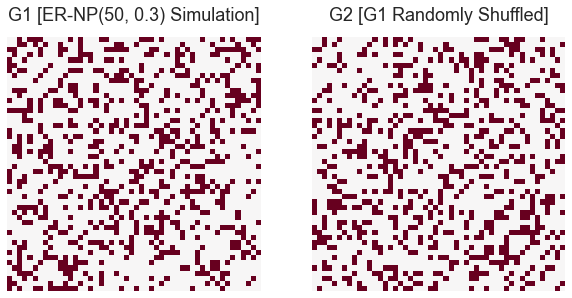

In [4]:
import matplotlib.pyplot as plt
from graspologic.plot import heatmap

fig, axs = plt.subplots(1,2,figsize=(10, 5))
heatmap(G1, cbar=False, title = 'G1 [ER-NP(50, 0.3) Simulation]', ax=axs[0])
_ = heatmap(G2, cbar=False, title = 'G2 [G1 Randomly Shuffled]', ax=axs[1])

Now, let's solve the graph matching problem.

In [5]:
gmp = GraphMatch()
gmp = gmp.fit(G1,G2)
G2 = G2[np.ix_(gmp.perm_inds_, gmp.perm_inds_)]
print("Number of edge disagreements: ", np.sum(abs(G1-G2)))

Number of edge disagreements:  0.0


So, we've exactly recovered the correct permutation - note that this won't always be true.

### Adding seed nodes

Next, we explore the use of "seed" nodes. Imagine you have two networks that you want to match, but you already know that a handful of these nodes are correctly paired. These nodes are called seeds, which you can incorporate into
the optimization in `graspologic` via techniques described in {cite:t}`fishkind2019seeded`.

For this example, we use a slightly different network model - we create two stochastic block models, but the edges are *correlated* so that the two networks are similar but not exactly the same.

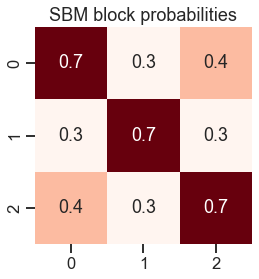

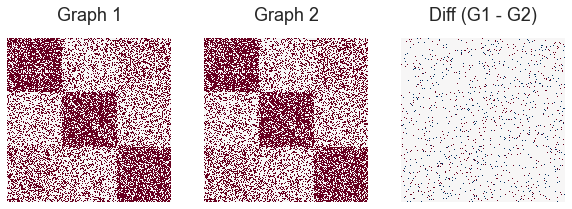

In [10]:
import seaborn as sns 
from graspologic.simulations import sbm_corr

sns.set_context('talk')

np.random.seed(8888)

directed = False
loops = False
n_per_block = 75
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
n_verts = block_members.sum()
rho = .9
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(block_probs, cbar=False, annot=True, square=True, cmap="Reds", ax=ax)
ax.set_title("SBM block probabilities")

A1, A2 = sbm_corr(block_members, block_probs, rho, directed=directed, loops=loops)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2, ax=axs[1], cbar=False, title="Graph 2")
_ = heatmap(A1 - A2, ax=axs[2], cbar=False, title="Diff (G1 - G2)")

Here we see that after shuffling the second graph, there are many more edge disagreements, as expected.

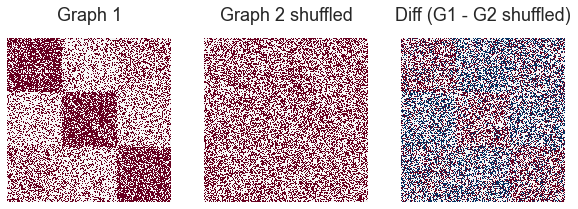

In [11]:
node_shuffle_input = np.random.permutation(n_verts)
A2_shuffle = A2[np.ix_(node_shuffle_input, node_shuffle_input)]
node_unshuffle_input = np.array(range(n_verts))
node_unshuffle_input[node_shuffle_input] = np.array(range(n_verts))

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_shuffle, ax=axs[1], cbar=False, title="Graph 2 shuffled")
_ = heatmap(A1 - A2_shuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2 shuffled)")

First, we will run graph matching on graph 1 and the shuffled graph 2 with no seeds, and return the match ratio, that is the fraction of vertices that have been correctly matched.

Match Ratio with no seeds:  0.013333333333333308


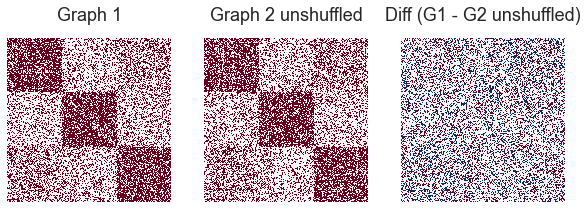

In [12]:
sgm = GraphMatch()
sgm = sgm.fit(A1,A2_shuffle)
A2_unshuffle = A2_shuffle[np.ix_(sgm.perm_inds_, sgm.perm_inds_)]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_unshuffle, ax=axs[1], cbar=False, title="Graph 2 unshuffled")
heatmap(A1 - A2_unshuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2 unshuffled)")

match_ratio = 1-(np.count_nonzero(abs(sgm.perm_inds_-node_unshuffle_input))/n_verts)
print("Match Ratio with no seeds: ", match_ratio)

While the predicted permutation for graph 2 did recover the basic structure of the stochastic block model (i.e. graph 1 and graph 2 look qualitatively similar), we see that the number of edge disagreements between them is still quite high, and the match ratio quite low. 

Next, we will run SGM with 10 randomly selected seeds. Although 10 seeds is only about 4% of the 300 node graph, we will observe below how much more accurate the matching will be compared to having no seeds.

Match Ratio with 10 seeds:  1.0


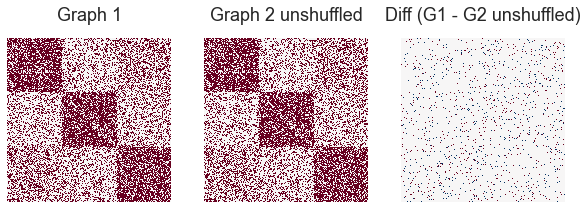

In [13]:
import random

W1 = np.sort(random.sample(list(range(n_verts)),10))
W1 = W1.astype(int)
W2 = np.array(node_unshuffle_input[W1])
    
sgm = GraphMatch()
sgm = sgm.fit(A1,A2_shuffle,W1,W2)
A2_unshuffle = A2_shuffle[np.ix_(sgm.perm_inds_, sgm.perm_inds_)]

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
heatmap(A1, ax=axs[0], cbar=False, title="Graph 1")
heatmap(A2_unshuffle, ax=axs[1], cbar=False, title="Graph 2 unshuffled")
heatmap(A1 - A2_unshuffle, ax=axs[2], cbar=False, title="Diff (G1 - G2 unshuffled)")

match_ratio = 1-(np.count_nonzero(abs(sgm.perm_inds_-node_unshuffle_input))/n_verts)
print("Match Ratio with 10 seeds: ", match_ratio)

### Graphs with different numbers of nodes

I won't go into all of the details, but it is also possible to match networks 
with different numbers of nodes.

Here, we just create two correlated SBMs, and then remove some nodes from each block in one of the networks.

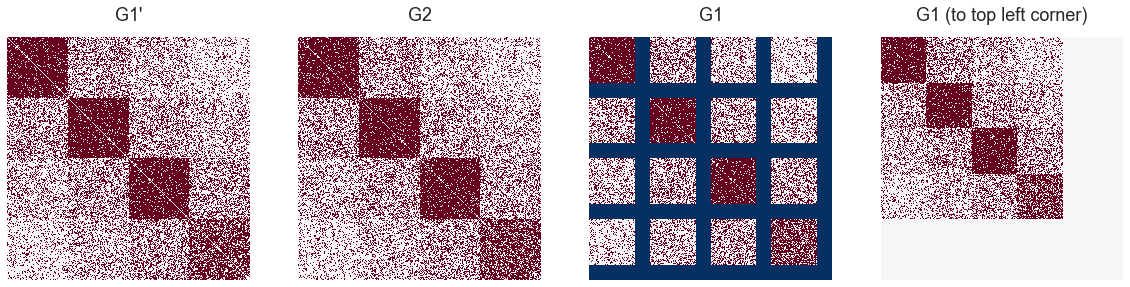

In [14]:
# simulating G1', G2, deleting 25 vertices
np.random.seed(1)

directed = False
loops = False
block_probs = [[0.9,0.4,0.3,0.2],
                [0.4,0.9,0.4,0.3],
                [0.3,0.4,0.9,0.4],
                [0.2,0.3,0.4,0.7]]
n =100
n_blocks = 4
rho = 0.5
block_members = np.array(n_blocks * [n])
n_verts = block_members.sum()
G1p, G2 = sbm_corr(block_members,block_probs, rho, directed, loops)
G1 = np.zeros((300,300))
c = np.copy(G1p)

step1 = np.arange(4) * 100 + 75
step2 = np.arange(5) * 75
step3 = np.arange(4) * 100
for i in range(len(step1)):
    block1 = np.arange(step1[i], step1[i]+25)
    c[block1,:] = -1
    c[:, block1] = -1
    for j in range(len(step3)):
        G1[step2[i]:step2[i+1], step2[j]:step2[j+1]] = G1p[step3[i]: step1[i], step3[j]:step1[j]]
        
topleft_G1 = np.zeros((400,400))
topleft_G1[:300,:300] = G1
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
heatmap(G1p, ax=axs[0], cbar=False, title="G1'")
heatmap(G2, ax=axs[1], cbar=False, title="G2")
heatmap(c, ax=axs[2], cbar=False, title="G1")
_ = heatmap(topleft_G1, ax=axs[3], cbar=False, title="G1 (to top left corner)")

Now, we have two networks which have two different sizes, and only some of the nodes in the smaller network are well represented in the other. We can still use graph matching here in `graspologic` - this code compares two different methods of doing so using techniques dubbed "padding" in {cite:t}`fishkind2019seeded`.

Match ratio of nodes remaining in G1, with naive padding: 0.10666666666666667
Match ratio of nodes remaining in G1, with adopted padding: 1.0


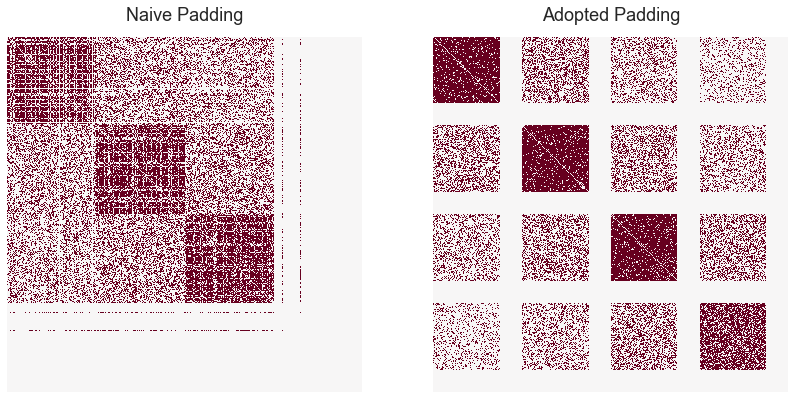

In [15]:
np.random.seed(1)

gmp_naive = GraphMatch(padding='naive')
seed1 = np.random.choice(np.arange(300),8)
seed2 = [int(x/75)*25 + x for x in seed1]
gmp_naive = gmp_naive.fit(G2, G1, seed2, seed1)
G1_naive = topleft_G1[gmp_naive.perm_inds_][:, gmp_naive.perm_inds_]

gmp_adopted = GraphMatch(padding='adopted')
gmp_adopted = gmp_adopted.fit(G2, G1, seed2, seed1)
G1_adopted = topleft_G1[gmp_adopted.perm_inds_][:, gmp_adopted.perm_inds_]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
heatmap(G1_naive, ax=axs[0], cbar=False, title="Naive Padding")
heatmap(G1_adopted, ax=axs[1], cbar=False, title="Adopted Padding")

naive_matching = np.concatenate([gmp_naive.perm_inds_[x * 100 : (x * 100) + 75] for x in range(n_blocks)])
adopted_matching = np.concatenate([gmp_adopted.perm_inds_[x * 100 : (x * 100) + 75] for x in range(n_blocks)])

print(f'Match ratio of nodes remaining in G1, with naive padding: {sum(naive_matching == np.arange(300))/300}')
print(f'Match ratio of nodes remaining in G1, with adopted padding: {sum(adopted_matching == np.arange(300))/300}')

## Application

In a recent paper, we applied these same tools for matching the nodes in the left and right *Drosophila* larva mushroom body connectome datasets, the same
ones you get from `graspologic.datasets.load_drosophila_left()` etc.

```{figure} ./images/gm-stat-conn.png

Figure from {cite:t}`chung2021statistical`.
```